In [4]:
import numpy as np
import matplotlib.pyplot as plt
import squidpy as sq
import scanpy as sc
import pandas as pd
import os
from PIL import Image
import imagecodecs
import tifffile as tff
from pyometiff import OMETIFFReader
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon

from sklearn.mixture import GaussianMixture
from scipy.stats import norm

import pickle
import json

# Defining functions

In [112]:
## Read nucleus/cell boundary .csv files + cell summary .csv

def read_boundary_files(data_dir,sample_dir):
    nucleus_bound=pd.read_csv(os.path.join(data_dir,sample_dir,'nucleus_boundaries.csv.gz'))
    cell_bound=pd.read_csv(os.path.join(data_dir,sample_dir,'cell_boundaries.csv.gz'))
    #transcripts=pd.read_csv(os.path.join(data_dir,sample_dir,'transcripts.csv.gz'))    
    #cells=pd.read_csv(os.path.join(data_dir,sample_dir,'cells.csv.gz'))

    return nucleus_bound,cell_bound


### =================================================================
## Read __morphology_focus.ome.tiff__ DAPI-fluorescence picture of slide
def read_ome_tiff(slide_type,data_dir,sample_dir):
    if slide_type=='focus':
        fn=os.path.join(data_dir,sample_dir,'morphology_focus.ome.tif')

    if slide_type=='mip':    
        fn=os.path.join(data_dir,sample_dir,'morphology_mip.ome.tif')

    if slide_type=='z_stack': 
        fn=os.path.join(data_dir,sample_dir,'morphology.ome.tif')
        
    reader = OMETIFFReader(fpath=fn)
    img_array,metadata,xml_metadata=reader.read()

    return img_array,metadata,xml_metadata



### =================================================================

## Create dataframe of mask polygon coordinates from json outputs, that Baysor created
def create_cell_bound_df(polygon_fn,seg):

    ## The cell names in segmentation.csv have a prefix in front of the cell name (i.e.'CRe50034e63-1')
    #  Extract that prefix and add it to the cell names coming from the json file to make them uniform
    prefix=seg.loc[~seg['cell'].isna(),'cell'].str.split('-',expand=True)[0].unique()

    if len(prefix)!=1:
        raise ValueError('Multiple prefixes in the segmentation.csv cell column => check the length of prefix variable in create_polygon_df() function!')

    prefix=prefix[0]
    
    import json
    # Opening JSON file
    f=open(polygon_fn)
    polygon=json.load(f)
    
    ## Init list to collect cell dfs with coordinates
    df_list=[]
    for n in range(len(polygon['geometries'])):
        ## Extract polygon coordinates
        coord=np.squeeze(np.array(polygon['geometries'][n]['coordinates']))
        
        if coord.shape[0]==0:
            print(coord)
        ## Add only cells with non-empty masks
        if (coord.shape[0])>3:

            ## Extract cell name
            cell_name=np.array([polygon['geometries'][n]['cell'],]*int(coord.shape[0]))

            ## Stack coordinates and cell_name and create dataframe
            coord_with_name=np.hstack((coord,cell_name.reshape(-1, 1)))
            colnames=['vertex_x_pixel','vertex_y_pixel','cell_id']
            df=pd.DataFrame(data=coord_with_name,columns=colnames)
            
            ## Keep cell name as an integer
            df['cell_id']=prefix + '-' + df['cell_id'].astype(int).astype(str)
            df_list.append(df)

    ## Concatenate all cell dfs into one
    df=pd.concat(df_list)    

    return df    


### =================================================================

## Calculate nucleus pixel metric: median/mean/max/mode of nucleus pixels
def return_polygon_pixel_metric(x,img_array,metric):
    from matplotlib import path
    import statistics as st
    import warnings
    warnings.filterwarnings("ignore")
       
    ## Extract the vertex points of nucleus polygon + boundaries of 
    polygon_vert=list(zip(x['vertex_x_pixel'],x['vertex_y_pixel']))

    ## Extract rectangle around nucleus -> get coordinates of nucleus polygon and create rectangle
    x_min=int(x['vertex_x_pixel'].min())
    x_max=int(x['vertex_x_pixel'].max())

    y_min=int(x['vertex_y_pixel'].min())
    y_max=int(x['vertex_y_pixel'].max())

    ## Create rectangle around nucleus
    nx,ny=x_max-x_min+1,y_max-y_min+1
    x,y=np.meshgrid(np.arange(nx), np.arange(ny))
    x,y=x.flatten()+x_min, y.flatten()+y_min

    points = np.vstack((x,y)).T

    ## Check if created rectangle's pixels are inside/outside of polygon -> 
    #  mask_: boolean mask; False: pixel outside of nucl. polygon; True: pixel inside of nucl. polygon)
    p=path.Path(polygon_vert)
    mask=p.contains_points(points)
    mask_=mask.reshape(ny,nx)

    ## Extract the pixel numbers of the pixels from inside the polygon 
    #  Subset original image to rectangle around nucleus (saves memory)
    sub_img_array=img_array[y_min:y_min+ny,x_min:x_min+nx]

    ## Calculate metric of nucleus pixels (rectangle masked with boolean mask)

    def return_indentity(x):
        return x
    
    metric_dict={'median':np.median,'mean':np.mean,'max':np.max,'mode':st.mode,'raw_vals':return_indentity}
    metric_func=metric_dict[metric]

    ## Check if there are at least 3 unique polygon vertices (for some points baysor outputs only 1 unique x-y pair)
    try:
        nucleus_polygon_metric=metric_func(sub_img_array[mask_].flatten())
    except ValueError:
         nucleus_polygon_metric=np.nan


    ## Plotting functions to showcase the pixels of the polygon for one nucleus
    #  For this, run the following code outside of ths function:

    #  cell_id='aaaejiml-1'
    #  nucleus_bound[nucleus_bound['cell_id']==cell_id].groupby('cell_id').apply(return_polygon_pixels,img_array=img_array)

    '''
    ## Plot the nuclues boolean mask 
    fig,ax=plt.subplots(1,4,figsize=(10,13))
    ax[0].imshow(mask_,origin='upper')

    ## Plot the polygon with GeoPandas dataframe for given cell
    nucleus_polygons.loc[nucleus_polygons.index.isin(['aaaejiml-1']),:].plot(ax=ax[1],column='real_cell',cmap=reversed_map,legend=True,alpha=0.3)
    #nucleus_polygons.loc[nucleus_polygons.index.isin(['aaakgmde-1']),:].plot(ax=ax[1],column='real_cell',cmap=reversed_map,legend=True,alpha=0.3)
    ax[1].invert_yaxis()

    ## Show raw nucleus data taken from oiriginal image
    #  Subset original slide image to a rectangle around the nucleus 
    sub_img_array=img_array[y_min:y_min+ny,x_min:x_min+nx]
    img=ax[2].imshow(sub_img_array,origin='upper')

    ## Show nucleus masked with polygon + DAPI intensities inside of polygon
    sub_img_array[~mask_]=0
    img2=ax[3].imshow(sub_img_array,origin='upper')
    plt.colorbar(img2, ax=ax[3])
    plt.show()

    '''
    return nucleus_polygon_metric



# Load files

In [111]:
data_dir="/data/gpfs/projects/punim2121/Atherosclerosis/xenium_data/"#processed_data/cell_segmentation"

## Drop scratch folders that start with "._"
panel_dir=[f for f in os.listdir(data_dir) if ('Panel' in f and '._' not in f)]
panel_dir.sort()


for panel in panel_dir[0:1]:
    panel_dir=os.path.join(data_dir,panel)
 
    ## Loop over all samples in a batch
    for sample_name in os.listdir(panel_dir)[0:]:
        sample_dir=os.path.join(data_dir,panel,sample_name)

        if os.path.isdir(sample_dir) and 'P1_H' in sample_dir:
            sample_dict={}
            
            ## Extract Panel_Sample_name as string
            panel_sample_name='_'.join([panel.split('_')[-1],sample_name.split('__')[2]])
            print(panel_sample_name)

            ## Load DAPI fluorescent-stained slide image
            # Select one slide_type ('mip'/'focus'/z_stack') file to load and 
            slide_type='mip'
            img_array,metadata,xml_metadata=read_ome_tiff(slide_type,data_dir,sample_dir)
            print('Slide loaded')

            ## Create baysor output folder path
            baysor_out_fold=os.path.join(data_dir,'processed_data/cell_segmentation',panel_sample_name,'baysor_output')

            ## Get only name of folders to loop over in baysor_output folder
            bays_model_dirlist=[filename for filename in os.listdir(baysor_out_fold) if os.path.isdir(os.path.join(baysor_out_fold,filename))]
            
            ### Loop over baysor segmentation models and extract cell mask polygon metrics
            for bays_model_name in bays_model_dirlist:
                print(bays_model_name)
                seg_fn=os.path.join(baysor_out_fold,bays_model_name,'segmentation.csv')
                seg=pd.read_csv(seg_fn)

                polygon_fn=os.path.join(baysor_out_fold,bays_model_name,'segmentation_polygons.json')
                cell_bound=create_cell_bound_df(polygon_fn,seg)

                ## Extract pixels of cell mask polygons (identified by Baysor model) and return a dataframe with some metrics of these pixel 
                #  intensities
                metric_df_list=[]
                metric_list=['median','mean','max','mode','raw_vals']
                for metric in metric_list:
                    temp_df=cell_bound.groupby('cell_id').apply(return_polygon_pixel_metric,img_array=img_array,metric=metric)
                    metric_df_list.append(temp_df)                
                #del img_array               
                nucleus_polygon_pixel_metrics=pd.concat(metric_df_list,axis=1)
                nucleus_polygon_pixel_metrics.columns=metric_list
                print('Nuclear polygon metrics calculated')


                ## Save the processed data as a dictionary
                sample_dict['cell_bound']=cell_bound
                sample_dict['nucleus_polygon_pixel_metrics']=nucleus_polygon_pixel_metrics
                
                proc_dir=os.path.join(data_dir,'processed_data/true_cell_filtering/baysor',panel_sample_name,bays_model_name)
                
                if not os.path.isdir(proc_dir):
                    os.makedirs(proc_dir)
                    print(f'Created directory: {proc_dir}')

                fpath=os.path.join(proc_dir,panel_sample_name+'.pickle')
                pickle.dump(sample_dict, open(fpath, "wb"))
                print(f'{panel_sample_name}-{bays_model_name} saved as pickle\n')
            
            

Panel1_P1_H
Key not found: 'NoneType' object has no attribute 'iter'
Key not found: 'NoneType' object has no attribute 'iter'
Slide loaded
assignments_cellpose_baysor-CPn_10


/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Nuclear polygon metrics calculated
Created directory: /data/gpfs/projects/punim2121/Atherosclerosis/xenium_data/processed_data/true_cell_filtering/baysor/Panel1_P1_H/assignments_cellpose_baysor-CPn_10
Panel1_P1_H-assignments_cellpose_baysor-CPn_10 saved as pickle

assignments_cellpose_baysor-CPc_4


/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Nuclear polygon metrics calculated
Panel1_P1_H-assignments_cellpose_baysor-CPc_4 saved as pickle

assignments_cellpose_baysor-CPn_4


/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Nuclear polygon metrics calculated
Created directory: /data/gpfs/projects/punim2121/Atherosclerosis/xenium_data/processed_data/true_cell_filtering/baysor/Panel1_P1_H/assignments_cellpose_baysor-CPn_4
Panel1_P1_H-assignments_cellpose_baysor-CPn_4 saved as pickle

assignments_cellpose_baysor-CPn_6


/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Nuclear polygon metrics calculated
Created directory: /data/gpfs/projects/punim2121/Atherosclerosis/xenium_data/processed_data/true_cell_filtering/baysor/Panel1_P1_H/assignments_cellpose_baysor-CPn_6
Panel1_P1_H-assignments_cellpose_baysor-CPn_6 saved as pickle

assignments_cellpose_baysor-CPc_10
[]
[]


/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Nuclear polygon metrics calculated
Created directory: /data/gpfs/projects/punim2121/Atherosclerosis/xenium_data/processed_data/true_cell_filtering/baysor/Panel1_P1_H/assignments_cellpose_baysor-CPc_10
Panel1_P1_H-assignments_cellpose_baysor-CPc_10 saved as pickle

assignments_cellpose_baysor-CPc_6
[]


/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/gpfs/projects/punim2121/anaconda3/envs/xenium/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Nuclear polygon metrics calculated
Created directory: /data/gpfs/projects/punim2121/Atherosclerosis/xenium_data/processed_data/true_cell_filtering/baysor/Panel1_P1_H/assignments_cellpose_baysor-CPc_6
Panel1_P1_H-assignments_cellpose_baysor-CPc_6 saved as pickle



## Distribution of nucleus metric + setting the nuclei metric threshold

/tmp/ipykernel_134302/228316998.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  max_var=gmm.covariances_[np.where(np.max(gmm.means_))]
/tmp/ipykernel_134302/228316998.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  max_var=gmm.covariances_[np.where(np.max(gmm.means_))]
/tmp/ipykernel_134302/228316998.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  max_var=gmm.covariances_[np.where(np.max(gmm.means_))]
/tmp/ipykernel_134302/228316998.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  max_var=gmm.covariances_[np.where(np.ma

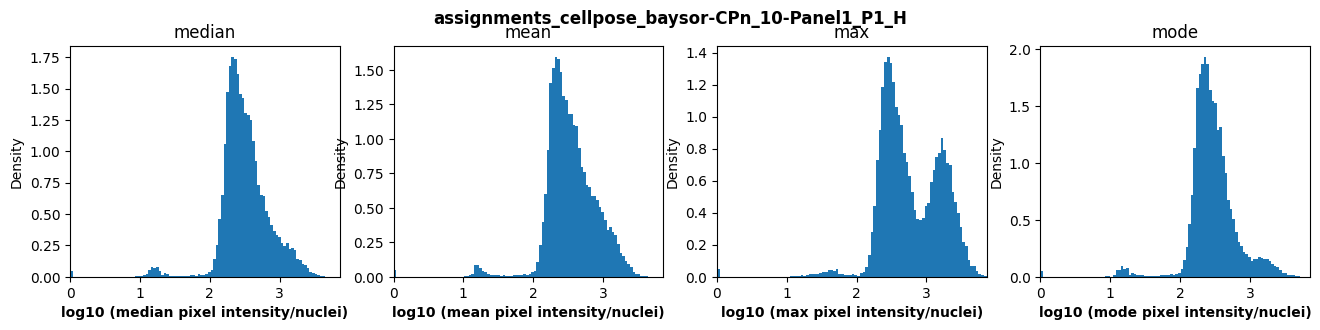

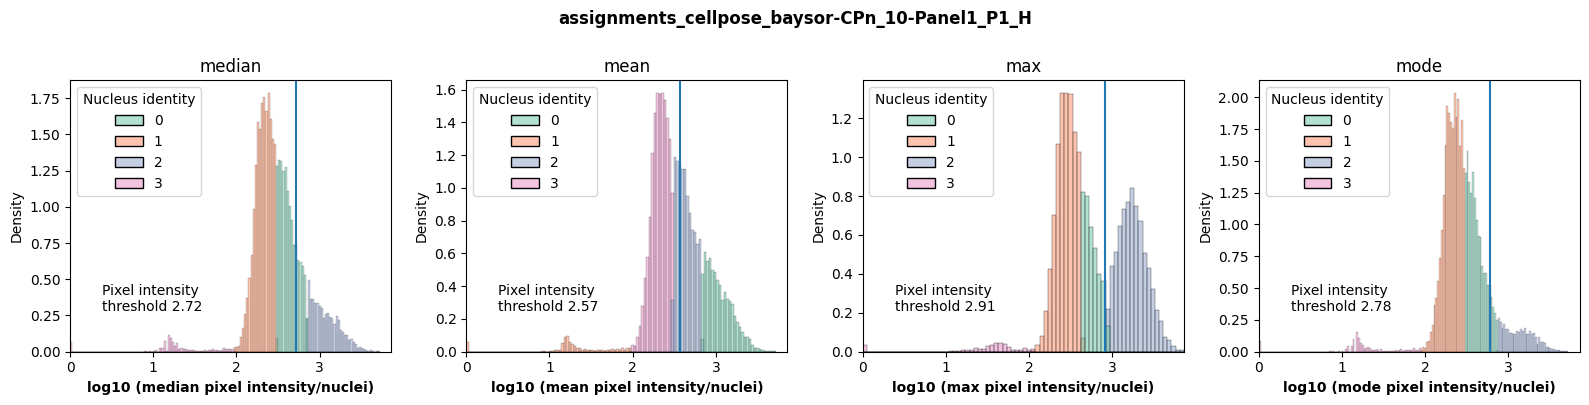

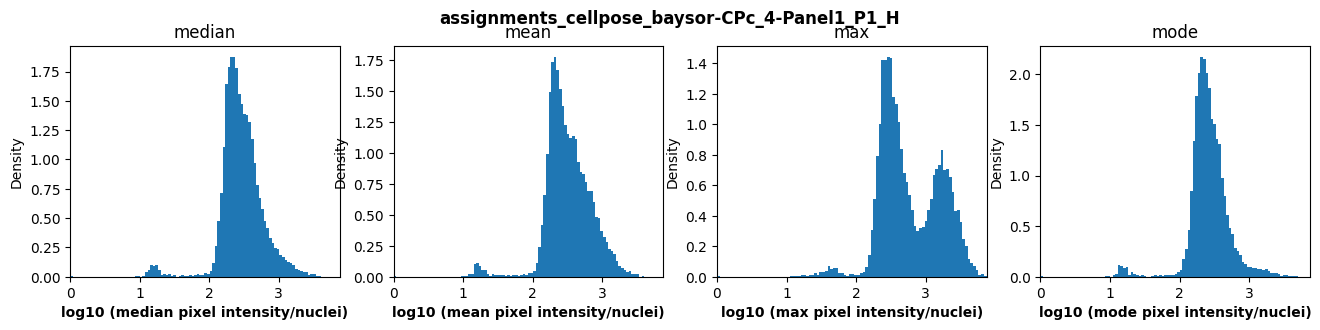

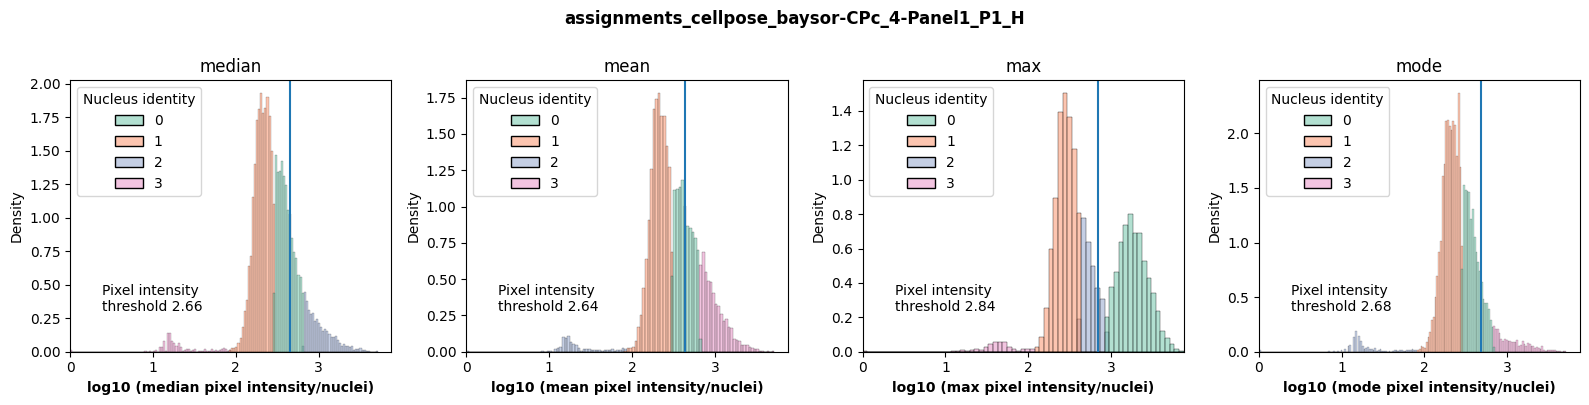

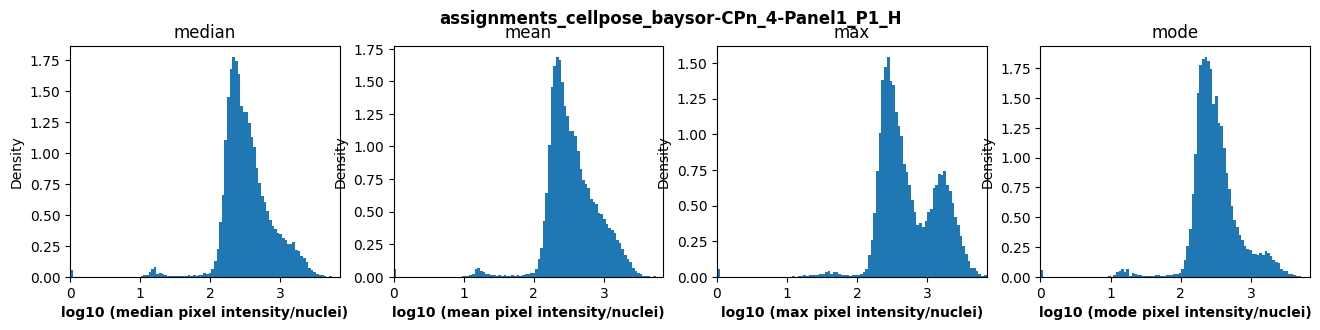

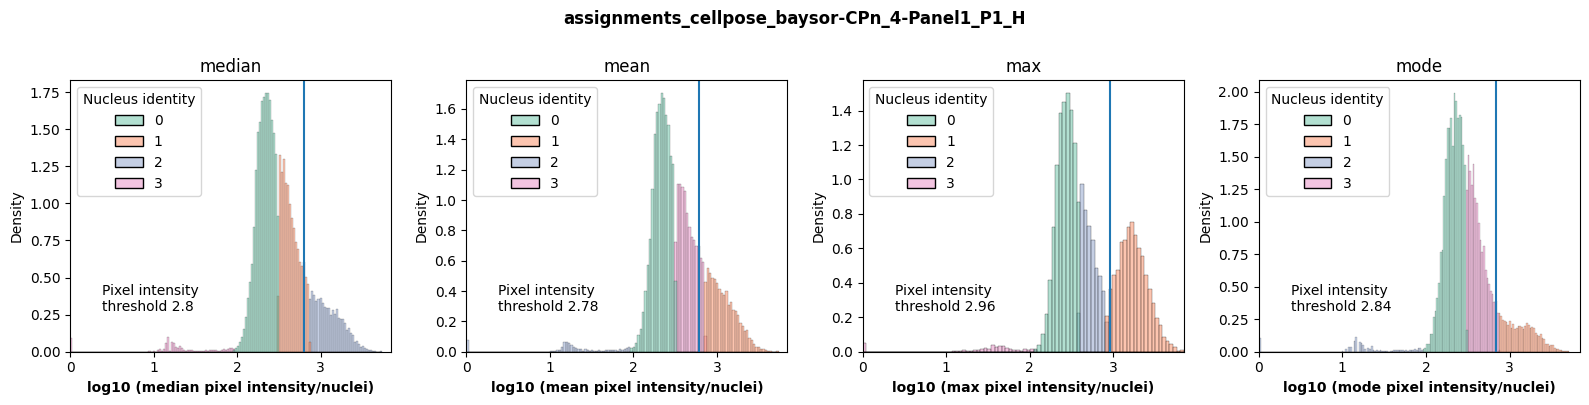

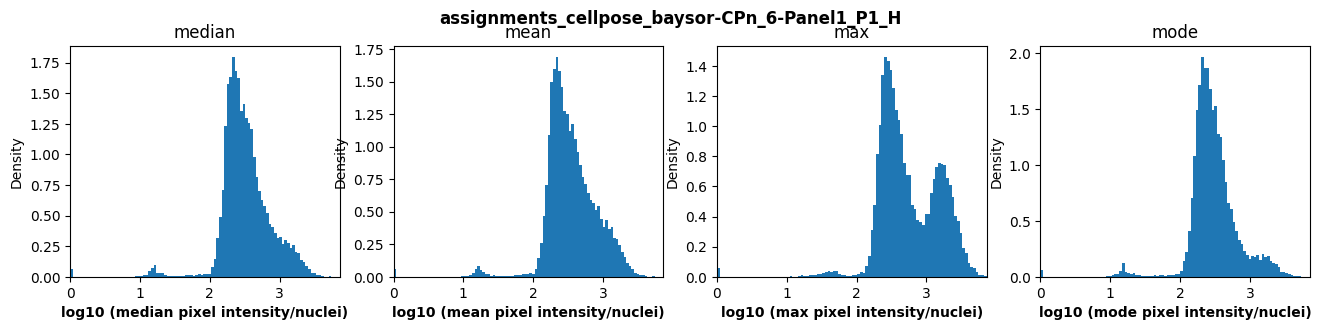

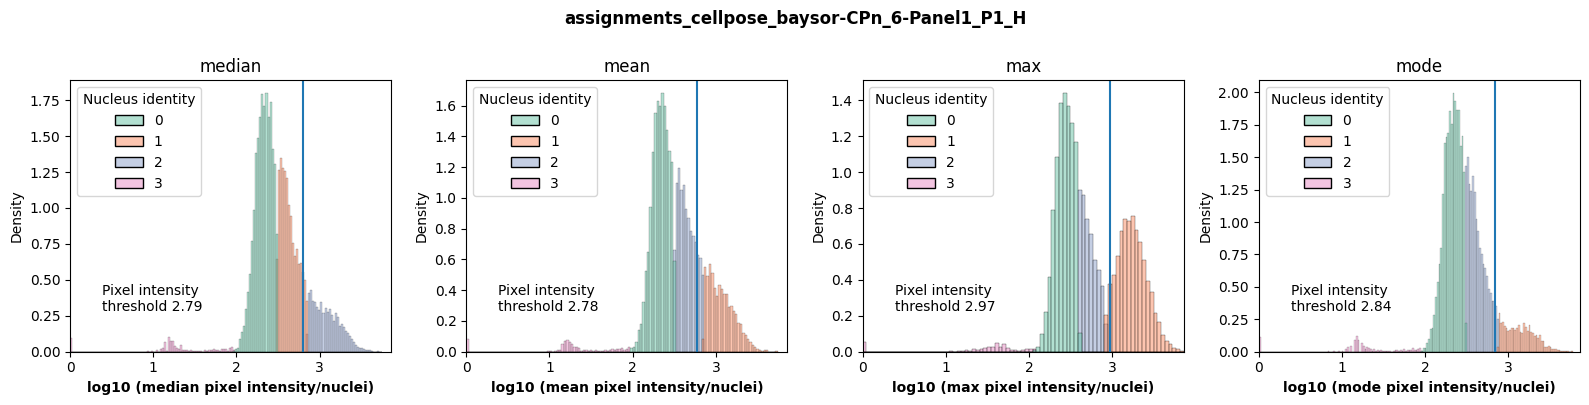

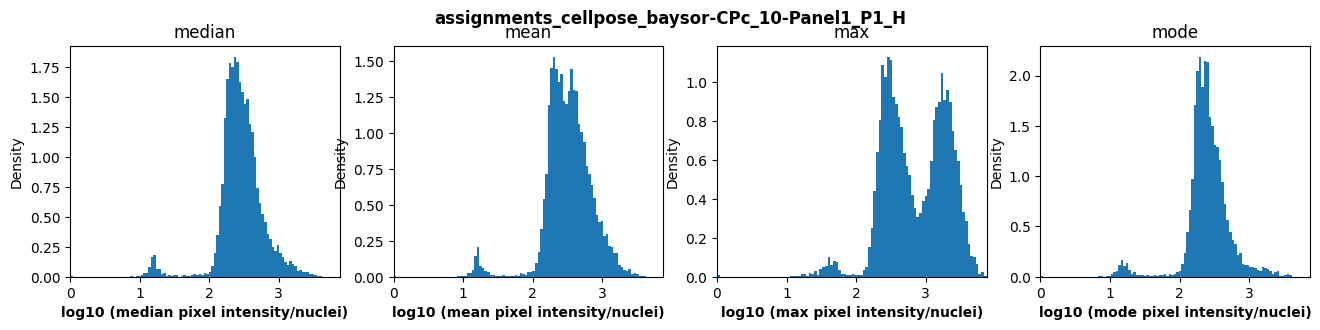

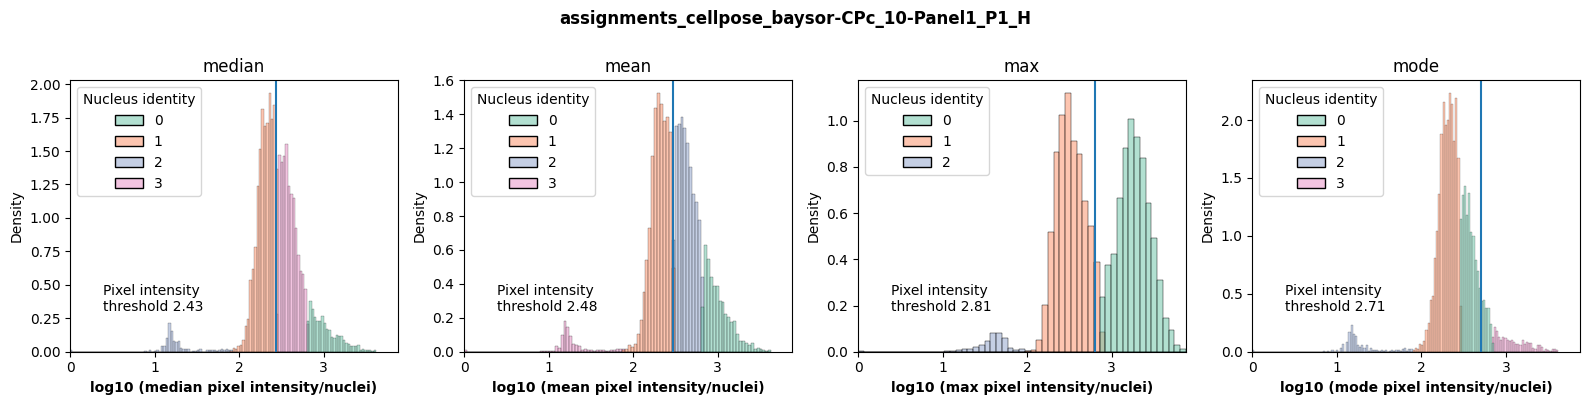

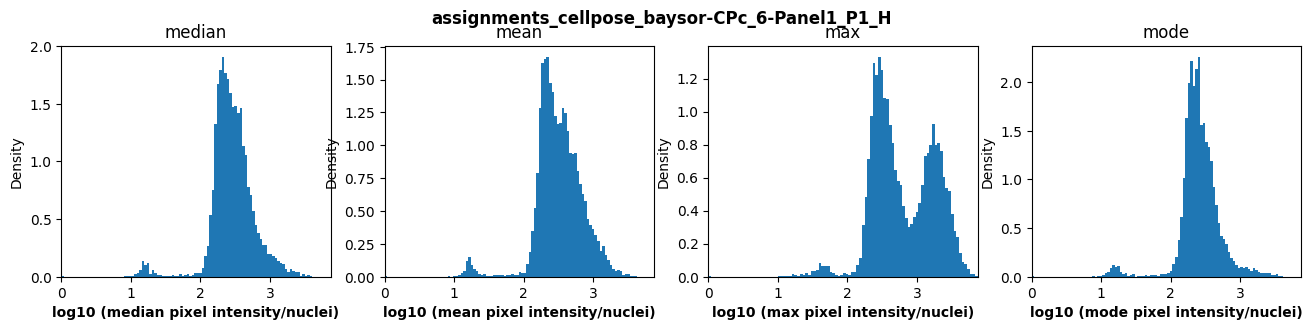

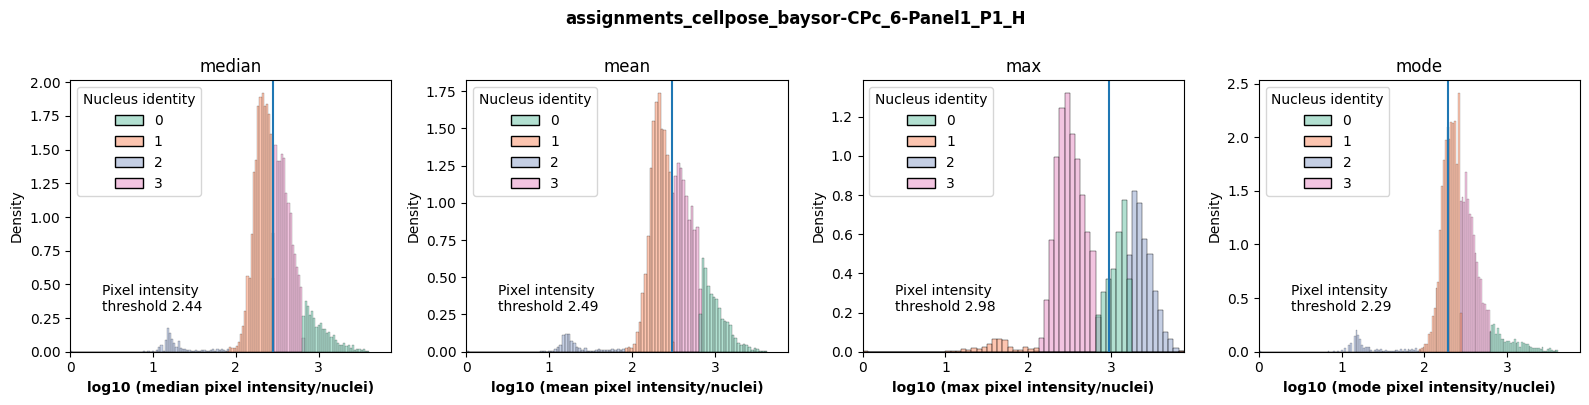

In [113]:
import math
metric_list=['median','mean','max','mode']

data_dir="/Volumes/T7/Plaque_Xenium_data"
data_dir="/data/gpfs/projects/punim2121/Atherosclerosis/xenium_data/"
#proc_dir=os.path.join(data_dir,'processed_data','true_cell_filtering','baysor')

## Drop scratch folders that start with "._"
panel_dir=[f for f in os.listdir(data_dir) if ('Panel' in f and '._' not in f)]
panel_dir.sort()


thr_dict={}

for panel in panel_dir[0:1]:
    panel_dir=os.path.join(data_dir,panel)
    sample_name_list=os.listdir(panel_dir)
    sample_name_list.sort()


    ## Loop over all samples 
    for sample_name in sample_name_list[0:]:
        sample_dir=os.path.join(data_dir,panel,sample_name)
        #print(sample_name)
        if os.path.isdir(sample_dir) and 'P1_H' in sample_dir:

            panel_sample_name='_'.join([panel.split('_')[-1],sample_name.split('__')[2]])
            cellf_sample_dirn=os.path.join(data_dir,'processed_data','true_cell_filtering','baysor',panel_sample_name)
            
            bays_model_dirlist=os.listdir(cellf_sample_dirn)

            thr_dict[panel_sample_name]={}

            for bays_model_name in bays_model_dirlist:
                thr_dict[panel_sample_name][bays_model_name]={}

                proc_dir=os.path.join(cellf_sample_dirn,bays_model_name)
                pkl_fn=os.path.join(proc_dir,panel_sample_name+'.pickle')

                sample_dict=pickle.load(open(pkl_fn, "rb"))

                #sample_dict['nucleus_bound']=nucleus_bound
                #sample_dict['cell_bound']=cell_bound
                nucleus_polygon_pixel_metrics=sample_dict['nucleus_polygon_pixel_metrics']

                nrows=1
                ncols=math.ceil(len(metric_list)/nrows)

                fig1=plt.figure(figsize=(ncols*4,nrows*3))
                fig2=plt.figure(figsize=(ncols*4,nrows*4))

                nucleus_polygon_pixel_metrics[metric_list]=nucleus_polygon_pixel_metrics[metric_list].fillna(0)
                xmin=np.log10(nucleus_polygon_pixel_metrics[metric_list].replace(0,1).values).min()
                xmax=np.log10(nucleus_polygon_pixel_metrics[metric_list].replace(0,1).values).max()

                for n,metric in enumerate(metric_list):

                    ax1=fig1.add_subplot(nrows,ncols,n+1)
                    metric_df=metric_df[~metric_df.isna()]
                    metric_df=np.log10(nucleus_polygon_pixel_metrics[metric].replace(0,1))
                    
                    ## PLot distribution of np.log10(nucleus metric)
                    ax1.hist(metric_df,bins=100,density=True);
                    ax1.set_title(metric)
                    ax1.set_xlabel(f'log10 ({metric} pixel intensity/nuclei)',fontweight='bold')
                    ax1.set_ylabel('Density')
                    ax1.set_xlim(xmin,xmax)
                    fig1.suptitle('-'.join([bays_model_name,panel_sample_name]),fontweight='bold',y=1)

                    
                    #### SET THRESHOLD OF NUCLEUS METRIC IN ORDER TO SEPARATE CORRECT/FALSELY LABELED NUCLEI BY BAYSOR (10X CELL SEGMENTATION MODEL)
                    ## FIT MIXED GAUSSIAN MODELS TO THE NUCLEUS METRIC DISTRIBUTION -> DISTRIBUTION OF NUCLEI WITH HIGHEST MEAN ARE REAL CELLS
                    X=metric_df.values.reshape(-1,1)

                    # Find the optimal number of components using the Akaike information criterion (AIC) or Bayesian information criterion (BIC)
                    n_components = np.arange(1, 5)
                    models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in n_components]
                    bic = [model.bic(X) for model in models]
                    optimal_n_components = n_components[np.argmin(bic)]

                    # Fit GMM with the optimal number of components
                    gmm = GaussianMixture(n_components=optimal_n_components, covariance_type='full', random_state=0)
                    #gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
                    gmm.fit(X)
                    labels = gmm.predict(X)

                    # Extract mean and variance of distribution with highest mean (==real nuclei population)
                    max_mean=np.max(gmm.means_)
                    max_var=gmm.covariances_[np.where(np.max(gmm.means_))]

                    ## SET THRESHOLD BASED ON THE QUANTILE OF THE GAUSSIAN DISTRIBUTION OF REAL NUCLEI
                    # Set quantile and then extract the threshold of a Gaussian scaled with the real nuclei distr. mean + variance
                    quant=0.01
                    int_thr_exponent=norm.ppf(quant, loc=max_mean, scale=max_var**0.5).flatten()[0]
                    thr_dict[panel_sample_name][bays_model_name][metric]=int_thr_exponent
                
                    # Plot the data and the fitted Gaussians
                    plot_df=pd.DataFrame({'values':X.reshape(-1,),'Nucleus identity':labels})
                    #plot_df['Nucleus identity']=plot_df['Nucleus identity'].replace({0:'True',1:'False'},regex=True)
                    
                    ax2=fig2.add_subplot(nrows,ncols,n+1)
                    
                    sns.histplot(data=plot_df,x='values',hue='Nucleus identity',ax=ax2,stat='density',palette='Set2')
                    ax2.axvline(int_thr_exponent)
                    ax2.set_title(metric)
                    ax2.set_xlabel(f'log10 ({metric} pixel intensity/nuclei)',fontweight='bold')
                    ax2.set_xlim(xmin,xmax)
                    ax2.text(xmin+(xmax-xmin)*0.1,ax2.get_ylim()[1]*0.15,f'Pixel intensity\nthreshold {round(int_thr_exponent,2)}')
                    fig2.suptitle('-'.join([bays_model_name,panel_sample_name]),fontweight='bold',y=1)

                    #print(f'Pixel intesity threshold: {int_thr_exponent}')
                    
                plt.tight_layout()    
           

## Plot cells with true/false labels

Cell identity
False cell    7594
True cell     6132
Name: count, dtype: int64


/tmp/ipykernel_134302/3293833380.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('summer')
/tmp/ipykernel_134302/3293833380.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('Greys')


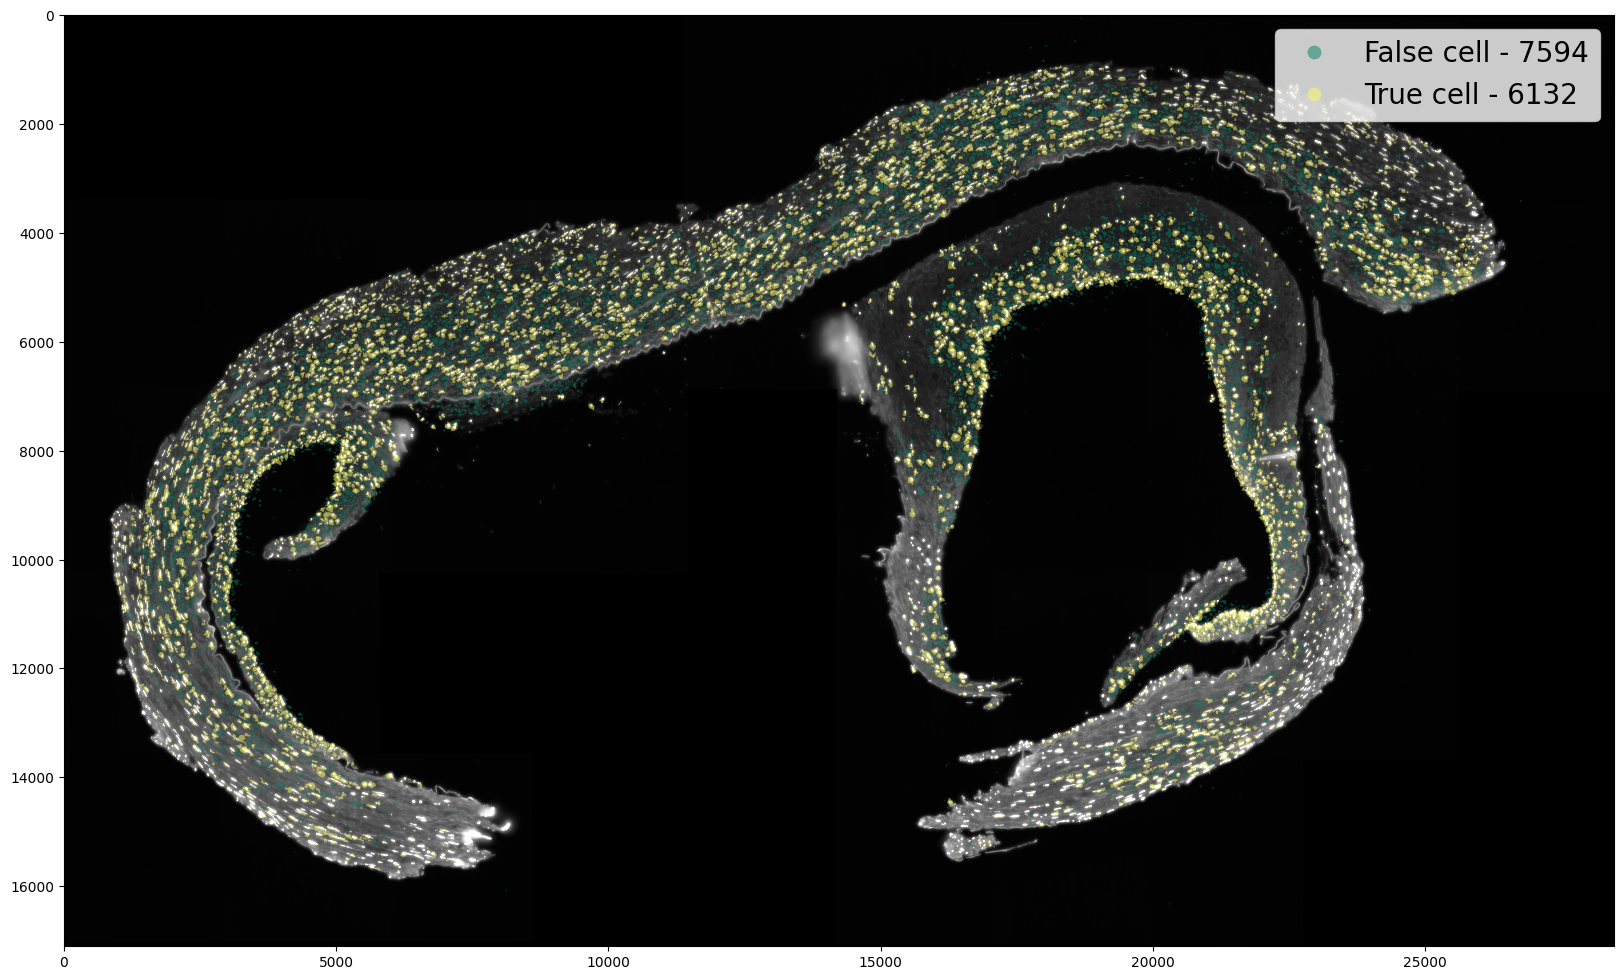

In [116]:



## Set pixel intensity threshold 
metric_name='max'
int_thr_exponent=thr_dict['Panel1_P1_H']['assignments_cellpose_baysor-CPc_10'][metric_name]
int_thr=10**int_thr_exponent


## Extract false nuclei that are below pixel intensity threshold
#false_nuclei=nucleus_polygon_pixel_metrics<int_thr
false_nuclei=nucleus_polygon_pixel_metrics[metric_list]<int_thr


### CREATE GEOPANDAS DATAFRAMES OF FOR PLOTTING TRUE/FALSE NUCLEI
##  Extract pixel coordinates of nuclei polygons 
#nucleus_poly_coordinates=nucleus_bound.groupby('cell_id').apply(lambda x: Polygon(zip(x['vertex_x_pixel'],x['vertex_y_pixel'])))
try:
    cell_poly_coordinates=cell_bound.groupby('cell_id').apply(lambda x: Polygon(zip(x['vertex_x_pixel'],x['vertex_y_pixel'])))
except ValueError:
    pass    

## Create GeoPandas dataframes containing pixel coordinates of nuclei polygons 
#nucleus_polygons=gpd.GeoDataFrame(index=nucleus_poly_coordinates.index,geometry=nucleus_poly_coordinates.values)
cell_polygons=gpd.GeoDataFrame(index=cell_poly_coordinates.index,geometry=cell_poly_coordinates.values)


## Add column indicating if cell is a true/false cell
cell_polygons['Cell identity']='True cell'
cell_polygons.loc[cell_polygons.index.isin(false_nuclei[false_nuclei[metric_name]].index),'Cell identity']='False cell'


#nucleus_polygons['Cell identity']='True cell'
#nucleus_polygons.loc[nucleus_polygons.index.isin(false_nuclei[false_nuclei].index),'Cell identity']='False cell'

print(cell_polygons['Cell identity'].value_counts())


## Plot cells with GeoPandas data indicating Cell identity (true/false) with colors overlaying
fig,ax=plt.subplots(1,1,figsize=(20,20))
orig_map=plt.cm.get_cmap('summer') 
reversed_map = orig_map#.reversed() 

## Add number of cells to the cell labels
conf_matrix=cell_polygons['Cell identity'].value_counts().sort_index()
leg_labels=[ind+ ' - ' +str(conf_matrix[ind]) for ind in conf_matrix.index]

cell_polygons.plot(ax=ax,column='Cell identity',cmap=reversed_map,legend=True,alpha=0.5,categorical=True,
                   legend_kwds={'fontsize':'20','labels':leg_labels})
#ax.set_facecolor('black')
ax.invert_yaxis()


## Plot original slide -> contrasted to the range of 0-0.98 quantile of pixel intesities 
#  -> whole slide appears brighter, as extreme intensive pixels get capped at 0.98 quantile 
orig_map=plt.cm.get_cmap('Greys') 
reversed_map = orig_map.reversed() 
img=ax.imshow((img_array),cmap=reversed_map,vmin=0, vmax=np.quantile(img_array,0.995))
#plt.colorbar(img, ax=ax)
plt.show()



In [96]:
a=cell_polygons['Cell identity'].value_counts()

['False cell - 10439', 'True cell - 5978']

In [100]:
[b for b in a]

[10439, 5978]

In [106]:
ax.get_legend_handles_labels()

([], [])